В этом ноутбуке выполнен основной анализ датасета по задаче https://www.kaggle.com/competitions/gan-getting-started/overview.
Посмотрели на то на сколько отделимы классы фотографий и картин моне, на распределение по световым каналам.

In [165]:
#!g1.1
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from IPython.display import clear_output

import warnings

warnings.filterwarnings('ignore')

In [23]:
#!g1.1
monet_path = 'data/monet_jpg'
photo_path = 'data/photo_jpg'

monet_jpgs = [f for f in os.listdir(monet_path) if os.path.isfile(os.path.join(monet_path, f))]
photo_jpgs = [f for f in os.listdir(photo_path) if os.path.isfile(os.path.join(photo_path, f))]

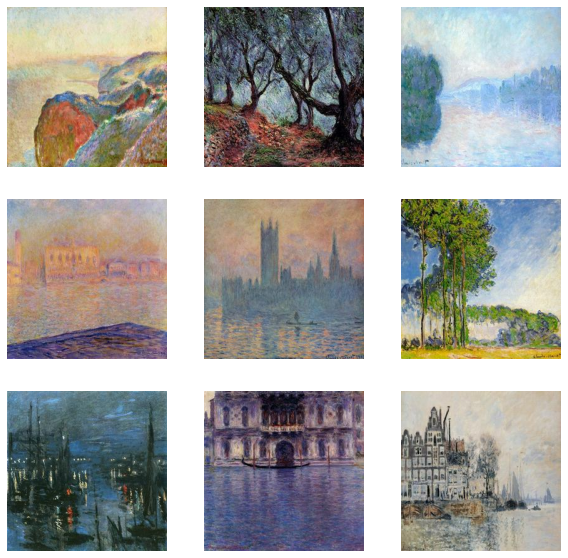

In [24]:
#!g1.1
plt.figure(figsize=(10, 10))
plt.title('картины Моне')
for i, pic in enumerate(monet_jpgs[:9]):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(os.path.join(monet_path, pic))
    plt.imshow(img)
    plt.axis('off')
plt.show();

In [25]:
#!g1.1
plt.figure(figsize=(10, 10))
plt.title('фотографии')
for i, pic in enumerate(photo_jpgs[:9]):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(os.path.join(photo_path, pic))
    plt.imshow(img)
    plt.axis('off')

plt.show();

Теперь построим простой классификатор изображений чтобы проверить сложность отделения картин Моне от фотографий, чтобы оценить возможности дескриминатора


In [26]:
#!g1.1
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torch import nn
import torch.nn.functional as F


In [70]:
#!g1.1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    transforms.Resize(48)])
batch_size = 4
classes = ('monet', 'image')

In [74]:
#!g1.1
import copy
from itertools import product
import random

class ImgDataset:
    def __init__(self, monet_jpgs, photo_jpgs, transform=lambda x: x):
        self.transform = transform
        self.imgs = [(self.transform(PIL.Image.open(os.path.join(monet_path, i))), 1) for i in monet_jpgs]\
                                     + [(self.transform(PIL.Image.open(os.path.join(photo_path, i))), 0) for i in photo_jpgs]
        random.shuffle(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx][0], self.imgs[idx][1]
    
    def __len__(self):
        return len(self.imgs)

Выберем простой сверточный классификатор для отделения картин моне и фотографий

In [104]:
#!g1.1
class Net(nn.Module):

    def __init__(self, n_channel, p=0.3):

        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channel, out_channels=128, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p=p),
            nn.Linear(in_features=7744, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [105]:
#!g1.1
from sklearn.metrics import roc_auc_score

In [166]:
#!g1.1
def train_step(model, optimizer, criterion, data, target):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output.squeeze(), torch.tensor(target, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy()

def validate(model, val_loader):
    with torch.no_grad():
        output = []
        target = []
        for batch_data, batch_target in val_loader:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)

            output += list(model(batch_data).detach().cpu().numpy())
            target += list(batch_target.detach().cpu().numpy())
        roc_auc = roc_auc_score(target, output)
    return roc_auc


def callback(loss_history, roc_auc_history, epoch, n_epoch, step, n_step):
    clear_output(wait=True)
    print(f'epoch: {epoch} / {n_epoch}, step: {step} / {n_step}')
    plt.figure(figsize=(16, 4), constrained_layout=False)
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='loss')
    plt.grid(':')
    plt.subplot(1, 2, 2)
    plt.plot(roc_auc_history, label='roc_auc')
    plt.grid(':')
    plt.legend();
    plt.show();
    
def train(model, train_loader, val_loader, optimizer, criterion, n_epoch=3, log_freq=30):
    loss_history = []
    roc_auc_history = []
    n_batch = len(train_loader)
    for epoch in range(n_epoch):
        batch_len = len(train_loader)
        for i, (data_batch, target_batch) in enumerate(train_loader):
            loss_history.append(train_step(model, optimizer, criterion, data_batch, target_batch))
            roc_auc_history.append(validate(model, val_loader))
            if (epoch * n_batch + i % log_freq == 1):
                callback(loss_history, roc_auc_history, epoch, n_epoch, i, n_batch)

In [167]:
#!g1.1
device = 'cuda'
model = Net(n_channel=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
batch_size = 64

In [94]:
#!g1.1
train_set = ImgDataset([img for _ in range(20) for img in monet_jpgs[:250]], photo_jpgs[:5000], transform=transform)
val_set = ImgDataset(monet_jpgs[250:], photo_jpgs[-250:], transform=transform)
train_loader = DataLoader(train_set, batch_size=16, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=100, pin_memory=True)

epoch: 0 / 1, step: 621 / 625


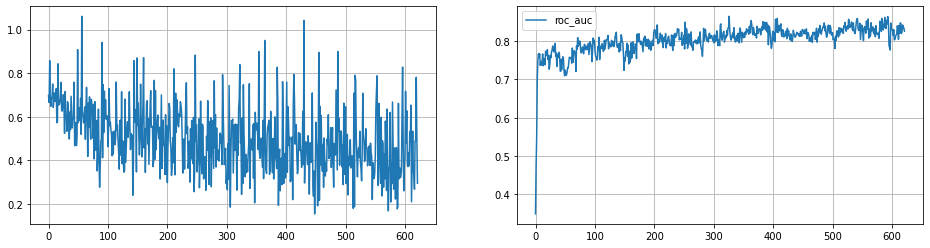

In [168]:
#!g1.1
train(model, train_loader, val_loader, optimizer, criterion, n_epoch=1, log_freq=20)

In [ ]:
#!g1.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [169]:
#!g1.1
train(model, train_loader, val_loader, optimizer, criterion, n_epoch=2, log_freq=20)

epoch: 0 / 2, step: 621 / 625


In [170]:
#!g1.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)


epoch: 0 / 1, step: 621 / 625


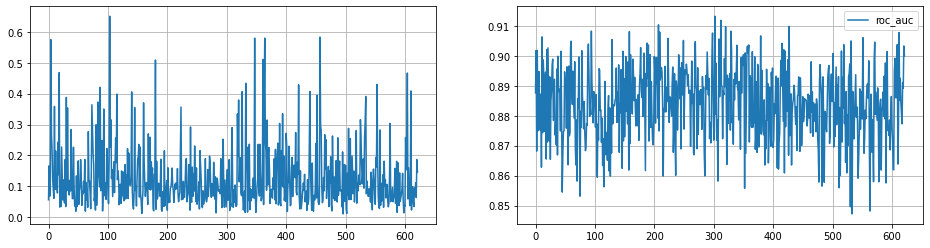

In [173]:
#!g1.1
train(model, train_loader, val_loader, optimizer, criterion, n_epoch=1, log_freq=20)

Простой сверточной сеткой удалось добиться качества примерно 0.88 roc_auc

Теперь посмотрим на распределение в цветовых каналах в датасете Моне и обычных фотографий

In [175]:
#!g1.1
monet_imgs = [PIL.Image.open(os.path.join(monet_path, pic)) for pic in monet_jpgs]
photo_imgs = [PIL.Image.open(os.path.join(photo_path, pic)) for pic in photo_jpgs]

In [185]:
#!g1.1
monet_r_channels = [np.array(img)[:,:,0] for img in monet_imgs]
monet_g_channels = [np.array(img)[:,:,1] for img in monet_imgs]
monet_b_channels = [np.array(img)[:,:,2] for img in monet_imgs]

In [186]:
#!g1.1
photo_r_channels = [np.array(img)[:,:,0] for img in photo_imgs]
photo_g_channels = [np.array(img)[:,:,1] for img in photo_imgs]
photo_b_channels = [np.array(img)[:,:,2] for img in photo_imgs]

In [193]:
#!g1.1
r_monet = np.concatenate([arr.flatten() for arr in monet_r_channels])
g_monet = np.concatenate([arr.flatten() for arr in monet_g_channels])
b_monet = np.concatenate([arr.flatten() for arr in monet_b_channels])

In [194]:
#!g1.1
r_photo = np.concatenate([arr.flatten() for arr in photo_r_channels])
g_photo = np.concatenate([arr.flatten() for arr in photo_g_channels])
b_photo = np.concatenate([arr.flatten() for arr in photo_b_channels])

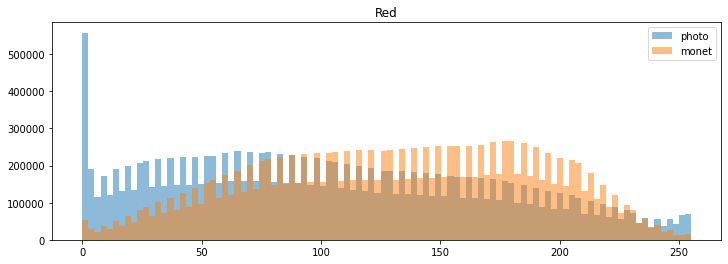

In [212]:
#!g1.1
plt.figure(figsize=(12, 4))
plt.title('Red')
plt.hist(r_photo[:int(15e6)],alpha=0.5, bins=100, label='photo')
plt.hist(r_monet[:int(15e6)],alpha=0.5, bins=100, label='monet')
plt.legend()
plt.show();

In [210]:
#!g1.1
#!g1.1
plt.figure(figsize=(12, 4))
plt.title('Green')
plt.hist(g_photo[:int(15e6)],alpha=0.5, bins=50, label='photo')
plt.hist(g_monet[:int(15e6)],alpha=0.5, bins=50, label='monet')
plt.legend()
plt.show();

In [211]:
#!g1.1
#!g1.1
plt.figure(figsize=(12, 4))
plt.title('Blue')
plt.hist(b_photo[:int(15e6)],alpha=0.5, bins=50, label='photo')
plt.hist(b_monet[:int(15e6)],alpha=0.5, bins=50, label='monet')
plt.legend()
plt.show();

Видим заметное смещение по всем каналам

In [ ]:
#!g1.1
